<a href="https://colab.research.google.com/github/cikufa/Cloud-DCGAN---FID/blob/main/gan_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import PIL
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import keras
from torch.distributions import MultivariateNormal
import pandas as pd
import seaborn as sns 
import scipy
from skimage.transform import resize
from torchvision.models import inception_v3
from PIL import Image 
import torchvision.transforms as transforms
import math

model_pth= 'gdrive/MyDrive/cloud_gan/modeltmp'
test_model_pth = 'gdrive/MyDrive/cloud_gan/model128'
data_pth = 'gdrive/MyDrive/cloud_gan/gan_dataset/understanding_cloud_organization/train_images' 
inception_path= 'gdrive/MyDrive/cloud_gan/inception_v3_google-1a9a5a14.pth'
out_pth = 'gdrive/MyDrive/cloud_gan/out128'

datalist=[]
for img in tqdm(os.listdir(data_pth)):
  datalist.append(img)
print(len(datalist), datalist[0])


FileNotFoundError: ignored

In [ ]:
def preprocess(img_dir, crop_idx=[5,7], IMAGE_SHAPE=(128,128,3)): #in: each img/ out: 35(or less) cropped, reshaped, adjusted value images 
  cropped_images= []
  with Image.open(img_dir) as img:
    img = img.resize((crop_idx[0]*IMAGE_SHAPE[0] , crop_idx[1]*IMAGE_SHAPE[1]),
                          Image.ANTIALIAS ) #(1400,2100)->(480, 672)=(5*96,7*96)  
    for c in range(crop_idx[1]): #width , col
      for r in range(crop_idx[0]): #heigh , row 
        cropped = img.crop((r*IMAGE_SHAPE[0], c*IMAGE_SHAPE[1], (r+1)*IMAGE_SHAPE[0], (c+1)*IMAGE_SHAPE[1]))
        cropped_blue=cropped.split()[2]
        a= np.random.random() # for randomizing the real data batch for evaluation 
        if (np.count_nonzero(cropped_blue) == IMAGE_SHAPE[0]*IMAGE_SHAPE[1] and a>0.5):
          cropped= torch.Tensor(cropped.getdata())
          #cropped= cropped.reshape(1,cropped.size()[1], int(math.sqrt(cropped.size()[0])), int(math.sqrt(cropped.size()[0]))) #1,3,128,128
          cropped = cropped / 127.5 - 1. #-1<training_data<1 , dtype : float64
#          cropped = torch.nn.functional.interpolate(cropped, size=(299, 299), mode='bilinear', align_corners=False)
          cropped_images.append(cropped)    
  # plt.imshow(cropped_images[0])
  # plt.show()
  return cropped_images 


def generate_real_samples(cropped_images, img_num, img_dir, datalist, batch_size):  # returns a batch of real data(img, label) with shape(128,128,3)
  #pdb.set_trace()
  while(len(cropped_images) < batch_size):
    cropped_images = cropped_images + preprocess(os.path.join(img_dir, datalist[img_num]))
    img_num = img_num + 1
  real_images= cropped_images.pop()
  for i in range(batch_size-1):
    real_images = torch.cat((real_images,cropped_images.pop()),0)
  #real_images = torch.nn.functional.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
  real_label = np.random.uniform(low= 0.8, high=1.2, size=(batch_size, 1))
  return cropped_images, img_num, real_images, real_label #(batch, 128*128 , 3)

def generate_fake_samples(g_model, latent_dim, batch_size):   # returns a batch of fake data(img, label)
	# generate points in latent space
  noise= np.random.normal(0,1,(batch_size,latent_dim))	# predict outputs
  fake_img = g_model.predict(noise)
	# create 'fake' class labels (0)
	#y = zeros((n_samples, 1))
  fake_label = np.random.uniform(low= 0.0, high=0.25, size=(batch_size, 1))
  return fake_img, fake_label


# create and save a plot of generated images
def save_plot(examples, saved_gen_num, fid, n=3):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'gdrive/MyDrive/cloud_gan/eval_generated/gen%03d_fid%03d.png' % ((saved_gen_num+1)*10  , fid)
	plt.savefig(filename)
	plt.close()

**COURSERA FID (frechet inception score)**

In [ ]:
import scipy.stats as stats
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return torch.norm(mu_x-mu_y)+torch.trace(sigma_x + sigma_y - matrix_sqrt(sigma_x @ sigma_y)*2)
  
# def preprocess(img):
#     img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
#     return img
    
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

def plot_fid(mu_fake , sigma_fake, mu_real, sigma_real):
  #plot
  indices = [2, 4, 5]
  fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
  fake_samples = fake_dist.sample((20,))
  real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
  real_samples = real_dist.sample((20,))

#  df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
  df_fake = pd.DataFrame(fake_samples.numpy()) #shape: (smaple, indices)
  # print("fake unique ", df_fake.index.is_unique)
  # print("faek dupl ", df_fake.index.duplicated())
  #df_fake.loc[~df_fake.index.duplicated(), :]
  df_real = pd.DataFrame(real_samples.numpy())
  # print("real  uni ", df_real.index.is_unique)
  # print("real dupl ", df_real.index.duplicated())
  #df_real.loc[~df_real.index.duplicated(), :]

  #df_fake["is_real"] = "no"
  #df_real["is_real"] = "yes"
  #df = pd.concat([df_fake, df_real])
  # plt.plot(df_fake[0])
  # plt.show()
  # plt.plot(df_real[0])
  # plt.show()
  
  # sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')
  # x = np.linspace(mu_fake - 3*sigma_fake, mu_fake + 3*sigma_fake, 100)
  # plt.plot(x, stats.norm.pdf(x, mu_fake, sigma_fake)) 
  # plt.show()
    
  df_fake["is_real"] = "no"
  df_real["is_real"] = "yes"
  df = pd.concat([df_fake, df_real])
  sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')
  
def mu_sigma_calc(inception_model, evalbatch, n_samples, rf, generator):
  features_list = []
  cur_samples = 0
  imn = int(np.random.random()*(len(datalist)-10))
  cropped=[]
  device= 'cpu'

  with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
  #try:
    #for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
    #for real_samples in tqdm(dataloader):
    for i in range(0, n_samples//evalbatch, evalbatch):
    # while cur_samples < n_samples:
      if (rf == 0): #getin real image features  
        cropped, imn, real_samples, reallbl  = generate_real_samples(cropped_images= cropped,
            img_num=imn, img_dir=imgdir, datalist=datalist, batch_size = evalbatch) #real sample: (evalbatch, 128*128 ,3)
      
        real_samples= (real_samples + 1)//2  # [-1,1] -> [0,1]
        real_samples= real_samples.reshape((evalbatch,128,128,3)) 
        real_samples= resize(real_samples, (evalbatch, 299, 299))
        real_samples= real_samples.reshape((evalbatch,3,299,299))
        real_samples= torch.tensor(real_samples)
        #real_samples = torch.nn.functional.interpolate(real_samples, size=(299, 299), mode='bilinear', align_corners=False) #RECENTLY ADDED
        real_features = inception_model(real_samples.to(device)).detach().to('cpu') # (evalbatch,2048)
        features_list.append(real_features)
        
      elif (rf == 1): #getin fake image features  
        noise = np.random.random((evalbatch, z_dim))
        fake_samples = (gen.predict(noise) + 1)/2  #(evalbatch, 128,128,3)
        #fake_samples= torch.tensor(fake_samples).reshape(evalbatch,3,128,128)
        #fake_samples = torch.nn.functional.interpolate(fake_samples, size=(299, 299), mode='bilinear', align_corners=False)
        fake_samples= resize(fake_samples, (evalbatch, 299, 299)) #(evalbatch, 299,299,3)
        fake_samples= fake_samples.reshape((evalbatch,3,299,299))
        fake_samples= torch.tensor(fake_samples)
        fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
        features_list.append(fake_features)  #(n_samples, 2048)

      #cur_samples += evalbatch
     
  #except:
  # else:
  #   print("Error in loop")
  
  features_all = torch.cat(features_list)
  mu = torch.mean(features_all, 0) #(1,2048)
  sigma = get_covariance(features_all) #(2048,2048)
  # print("mu , sigma", mu.shape, sigma.shape)
  # print("features", len(features_list), features_list[0].shape)
  return mu, sigma

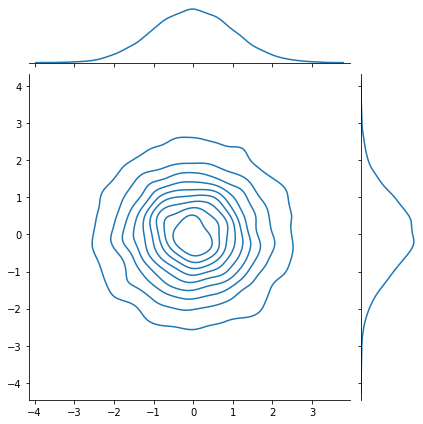

In [ ]:

from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

In [ ]:
# #test
import warnings
warnings.filterwarnings("ignore")

from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load(inception_path))
#inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode
inception_model.fc = torch.nn.Identity()
#gen.eval()
n=3
evalbatch = n*n
n_samples= 512 #1024
device= 'cpu'
z_dim = 100
# cr_, imn_, dataloader, lbl_  = generate_real_samples(cropped_images=[],
#           img_num=0, img_dir=imgdir, datalist=datalist, batch_size = evalbatch)

#real
mu_real1, sigma_real1 = mu_sigma_calc(inception_model, evalbatch, n_samples, 0, None)
mu_real2, sigma_real2 = mu_sigma_calc(inception_model, evalbatch, n_samples, 0, None)
print("frechet distance real1-real2:", frechet_distance(mu_real1, mu_real2, sigma_real1, sigma_real2).item())

with torch.no_grad():
  for i in range(7):
    g = f'gdrive/MyDrive/cloud_gan/model128/generator_0{(i+3)*10}.h5'
    gen = keras.models.load_model(g)
    #frechet
    mu_fake, sigma_fake = mu_sigma_calc(inception_model, evalbatch, n_samples, 1, gen)
    fid = frechet_distance(mu_fake, mu_real1, sigma_fake, sigma_real1).item()
    print(f"frechet distance real1-fake{10*(i+3)}:",fid)
    #monitor output
    fake , _ = generate_fake_samples(gen, z_dim, evalbatch)
    save_plot(fake, (i+3)*10, fid, n=3)


frechet distance real1-real2: 11.705864906311035
frechet distance real1-fake30: 61.01310729980469
frechet distance real1-fake40: 61.818809509277344
frechet distance real1-fake50: 55.22883605957031
frechet distance real1-fake60: 55.06769943237305
frechet distance real1-fake70: 57.07067108154297
frechet distance real1-fake80: 55.85044860839844
frechet distance real1-fake90: 56.73310470581055


**####################################################################################################################################################################################################################**
-----------------SSIM-------------------

In [ ]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

#______________________________________________________________________________

def create_window(window_size, channel=1):
    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

#________________________________________________________________________________

def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),
    pad = window_size // 2
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()
    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

In [ ]:
import keras
import torch 
ssim_batch= 10
cropped_images, img_num, real_ssim1, real_label = generate_real_samples([], 0, data_pth, datalist, ssim_batch)
cropped_images, img_num, real_ssim2, real_label = generate_real_samples([], 3, data_pth, datalist, ssim_batch)

#print((real_ssim[0]).shape)
noise = np.random.random((ssim_batch,100))
gen90 = keras.models.load_model('gdrive/MyDrive/cloud_gan/model128/generator_060.h5')
fake_ssim = (gen90.predict(noise).reshape(ssim_batch,3,128,128) + 1)/2
#print(len(fake_ssim), (fake_ssim[0]).shape)
ssim_r1f = ssim(torch.tensor(real_ssim1), torch.tensor(fake_ssim), val_range=255)
ssim_r2f = ssim(torch.tensor(real_ssim2), torch.tensor(fake_ssim), val_range=255)
ssim_rr = ssim(torch.tensor(real_ssim1), torch.tensor(real_ssim2), val_range=255)
print(ssim_r1f, ssim_r2f, ssim_rr)

for im in fake_ssim:
  im= (im.reshape(128,128,3))
  plt.imshow(im)
  plt.show()

NameError: ignored

--- MSE ---


In [ ]:
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np

def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])	
 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

noise= np.random.random((1,100))	# predict outputs
gan1 = keras.models.load_model('gdrive/MyDrive/cloud_gan/model128/generator_010.h5')
fake1 = gan1.predict(noise)
fake1 = (fake1[0]+1)/2.0
plt.imshow(fake1)
plt.show()
gan9 = keras.models.load_model('gdrive/MyDrive/cloud_gan/model128/generator_090.h5')
fake9 = gan9.predict(noise)
fake9 = (fake9[0]+1)/2.0
plt.imshow(fake9)
plt.show()
with Image.open('gdrive/MyDrive/cloud_gan/gan_dataset/understanding_cloud_organization/train_images/006bf7c.jpg'
) as real:
  real1 = real.crop((0,0,128,128))
  real2 = real.crop((128,0,256,128))
real1= np.array(real1)
real2= np.array(real2)

print(ssim(real1 , real2, multichannel=True))
print(ssim(real1 , fake1, multichannel=True))
print(ssim(real1 , fake9, multichannel=True))
print(mse(real1 , real2))
print(mse(real1 , fake1))
print(mse(real1 , fake9))


**############################################################################################################################################################################################################**
INCEPRION GIT PAPER